In [1]:
import sys
import timeit
import quandl
import random
import itertools
import numpy as np
import pandas as pd
from scipy import signal

import gym
from gym import spaces
from gym.utils import seeding

import sklearn.pipeline
import sklearn.preprocessing
from sklearn.linear_model import SGDRegressor
from sklearn.kernel_approximation import RBFSampler

%matplotlib inline
#import matplotlib
import matplotlib.pyplot as plt

---

In [2]:
quandl.ApiConfig.api_key = 'Y3ZsAjxvEuP8yXjmrJgE'
df = quandl.get_table('GSCR/GSPLY', supplier_exchange='NasdaqGS', supplier_ticker='PTLA')
df.head()

,publish_date,public_domain_date,accounting_as_of_date,supplier_name,supplier_isin,supplier_lei,supplier_exchange,supplier_ticker,customer_name,customer_isin,customer_lei,customer_exchange,customer_ticker,reporting_year,reporting_period,revenue_dependency,revenue_dependency_annotation
None,,,,,,,,,,,,,,,,,
0,2018-05-18,NaT,2018-03-31,"Portola Pharmaceuticals, Inc.",US7370101088,549300BM3O4O0CNBGJ64,NasdaqGS,PTLA,"Daiichi Sankyo Company, Limited",JP3475350009,353800XGIU2IHQGC9504,TSE,4568,2018.0,1.0,0.267309,Actual
1,2018-05-18,2018-03-01,2017-12-31,"Portola Pharmaceuticals, Inc.",US7370101088,549300BM3O4O0CNBGJ64,NasdaqGS,PTLA,"Daiichi Sankyo Company, Limited",JP3475350009,353800XGIU2IHQGC9504,TSE,4568,2017.0,99.0,0.332032,Actual
2,2018-05-18,2017-11-09,2017-09-30,"Portola Pharmaceuticals, Inc.",US7370101088,549300BM3O4O0CNBGJ64,NasdaqGS,PTLA,"Daiichi Sankyo Company, Limited",JP3475350009,353800XGIU2IHQGC9504,TSE,4568,2017.0,3.0,0.488660,Actual
3,2018-05-18,2017-08-09,2017-06-30,"Portola Pharmaceuticals, Inc.",US7370101088,549300BM3O4O0CNBGJ64,NasdaqGS,PTLA,"Daiichi Sankyo Company, Limited",JP3475350009,353800XGIU2IHQGC9504,TSE,4568,2017.0,2.0,0.470443,Actual
4,2018-05-18,2017-05-09,2017-03-31,"Portola Pharmaceuticals, Inc.",US7370101088,549300BM3O4O0CNBGJ64,NasdaqGS,PTLA,"Daiichi Sankyo Company, Limited",JP3475350009,353800XGIU2IHQGC9504,TSE,4568,2017.0,1.0,0.425312,Actual


In [3]:
df = df[df['customer_ticker'] == 'JNJ']
df.head()

,publish_date,public_domain_date,accounting_as_of_date,supplier_name,supplier_isin,supplier_lei,supplier_exchange,supplier_ticker,customer_name,customer_isin,customer_lei,customer_exchange,customer_ticker,reporting_year,reporting_period,revenue_dependency,revenue_dependency_annotation
None,,,,,,,,,,,,,,,,,
24,2018-05-18,2018-05-09,2018-03-31,"Portola Pharmaceuticals, Inc.",US7370101088,549300BM3O4O0CNBGJ64,NasdaqGS,PTLA,Johnson & Johnson,US4781601046,549300G0CFPGEF6X2043,NYSE,JNJ,2018.0,1.0,0.204696,Actual
25,2018-05-18,2018-03-01,2017-12-31,"Portola Pharmaceuticals, Inc.",US7370101088,549300BM3O4O0CNBGJ64,NasdaqGS,PTLA,Johnson & Johnson,US4781601046,549300G0CFPGEF6X2043,NYSE,JNJ,2017.0,99.0,0.120287,Actual
26,2018-05-18,2017-11-09,2017-09-30,"Portola Pharmaceuticals, Inc.",US7370101088,549300BM3O4O0CNBGJ64,NasdaqGS,PTLA,Johnson & Johnson,US4781601046,549300G0CFPGEF6X2043,NYSE,JNJ,2017.0,3.0,0.073766,Actual
27,2018-05-18,2017-08-09,2017-06-30,"Portola Pharmaceuticals, Inc.",US7370101088,549300BM3O4O0CNBGJ64,NasdaqGS,PTLA,Johnson & Johnson,US4781601046,549300G0CFPGEF6X2043,NYSE,JNJ,2017.0,2.0,0.074930,Actual
28,2018-05-18,2017-05-09,2017-03-31,"Portola Pharmaceuticals, Inc.",US7370101088,549300BM3O4O0CNBGJ64,NasdaqGS,PTLA,Johnson & Johnson,US4781601046,549300G0CFPGEF6X2043,NYSE,JNJ,2017.0,1.0,0.077906,Actual


In [4]:
portfolios = ['JNJ', 'PTLA']
start = '1996-01-01'
end = '2019-09-30'

In [5]:
jnj = quandl.get('EOD/JNJ', start_date=start, end_date=end)
ptla = quandl.get('EOD/PTLA', start_date=start, end_date=end)
print(len(jnj), len(ptla))

5978 1601


In [6]:
ptla.head()

,Open,High,Low,Close,Volume,Dividend,Split,Adj_Open,Adj_High,Adj_Low,Adj_Close,Adj_Volume
Date,,,,,,,,,,,,
2013-05-22,15.25,15.38,14.75,15.15,3378000.0,0.0,1.0,15.25,15.38,14.75,15.15,3378000.0
2013-05-23,15.00,15.35,14.90,15.15,306200.0,0.0,1.0,15.00,15.35,14.90,15.15,306200.0
2013-05-24,15.19,16.48,15.11,16.10,227900.0,0.0,1.0,15.19,16.48,15.11,16.10,227900.0
2013-05-28,16.35,21.34,16.12,18.10,233900.0,0.0,1.0,16.35,21.34,16.12,18.10,233900.0
2013-05-29,18.20,18.20,16.36,17.20,113300.0,0.0,1.0,18.20,18.20,16.36,17.20,113300.0


In [7]:
jnj = jnj[jnj.index >= '2013-05-22']
print(len(jnj), len(ptla))

1601 1601


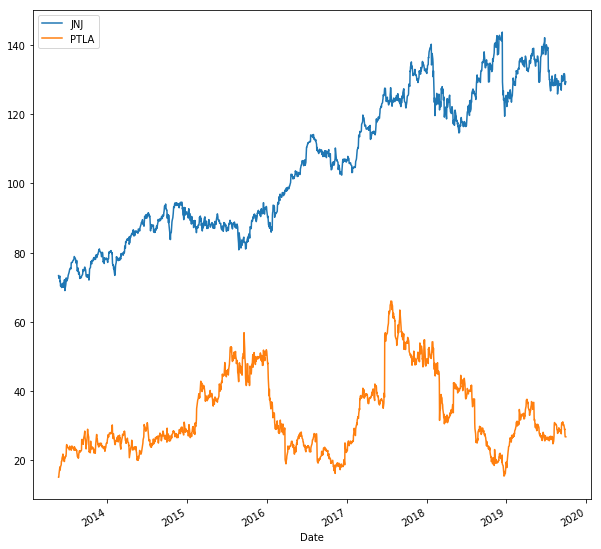

In [8]:
plt.figure(figsize=(10,10))
jnj['Adj_Close'].plot(label='JNJ')
ptla['Adj_Close'].plot(label='PTLA')
plt.legend()

In [9]:
df = pd.DataFrame(columns=portfolios, index=ptla.index)
df['JNJ'] = np.log(jnj['Adj_Close']) - np.log(jnj['Adj_Close'].shift(1))
df['PTLA'] = np.log(ptla['Adj_Close']) - np.log(ptla['Adj_Close'].shift(1))
df = df.iloc[1:]
df.head()

,JNJ,PTLA
Date,,
2013-05-23,-0.006692,0.000000
2013-05-24,-0.004482,0.060819
2013-05-28,0.009058,0.117093
2013-05-29,-0.022626,-0.051003
2013-05-30,0.003962,0.022990


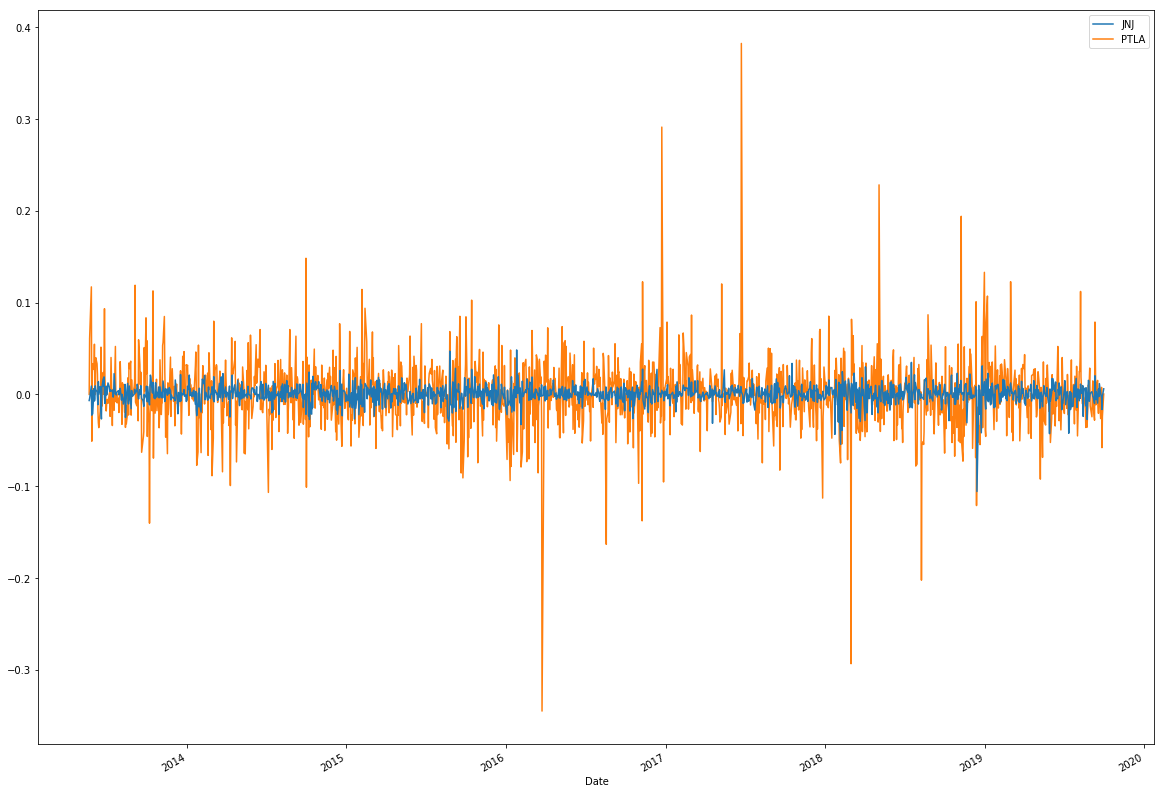

In [10]:
plt.figure(figsize=(20,15))
for idx, i in enumerate(portfolios):
    df[i].plot(label=i, zorder=3-idx)
plt.legend()

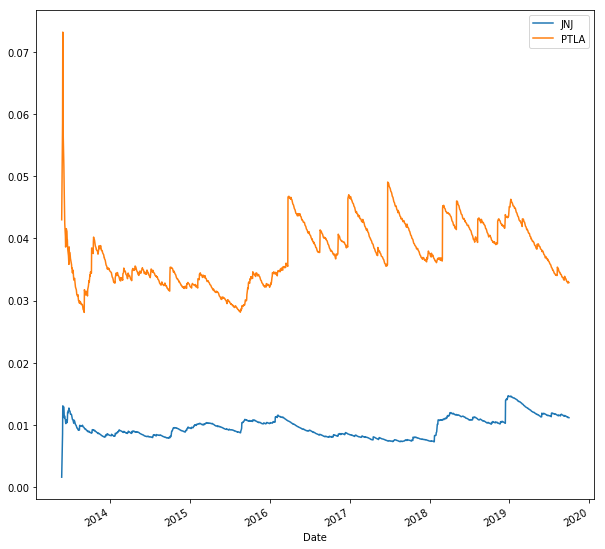

In [11]:
vol = df.ewm(span=252).std()
plt.figure(figsize=(10,10))
for i in portfolios:
    vol[i].plot(label=i)
plt.legend()

(1599, 2)


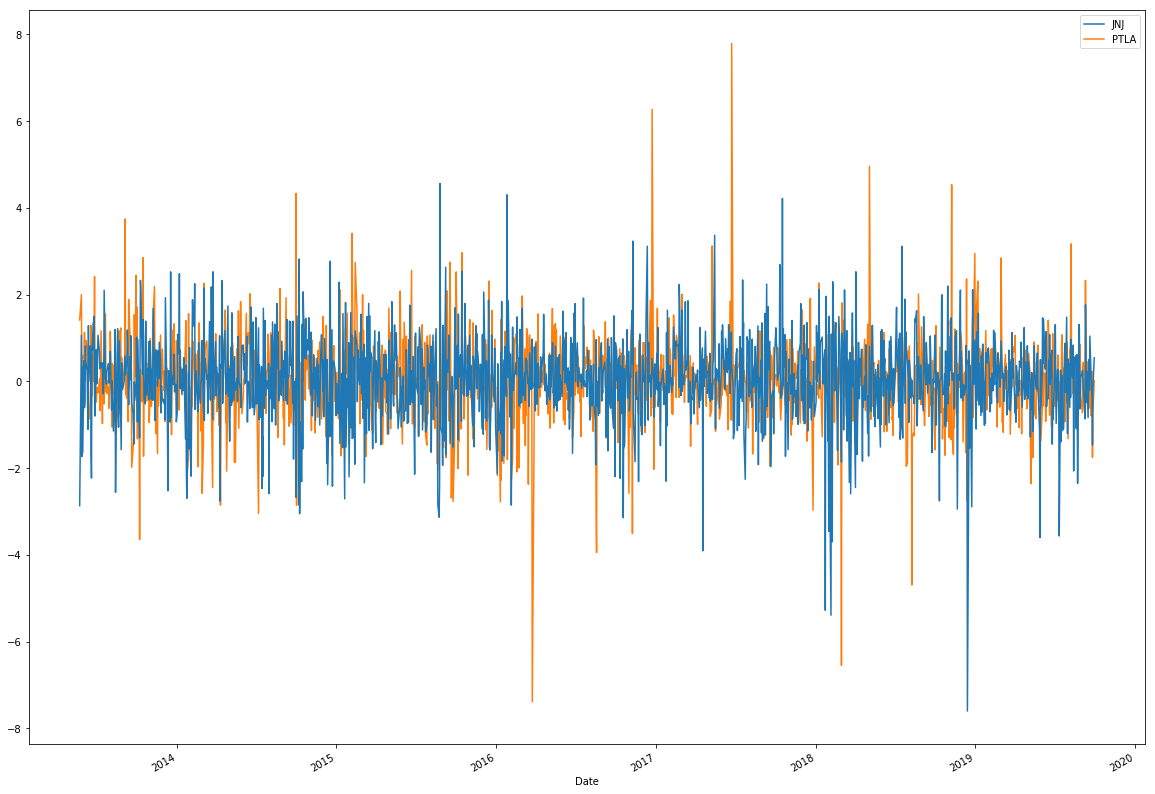

In [12]:
df = (df / vol)[1:]
print(df.shape)
plt.figure(figsize=(20,15))
for idx, i in enumerate(portfolios):
    df[i].plot(label=i, zorder=3-idx)
plt.legend()

In [13]:
fb_df = quandl.get_table('SMA/FBD', brand_ticker='JNJ')
fb_df = fb_df[fb_df['geography']=='United States']
fb_df.head()

/Users/Jay/anaconda3/lib/python3.6/site-packages/quandl/get_table.py:38: UserWarning: To request more pages, please set paginate=True in your         quandl.get_table() call. For more information see our documentation:         https://github.com/quandl/quandl-python/blob/master/FOR_ANALYSTS.md#things-to-note
  warnings.warn(Message.WARN_PAGE_LIMIT_EXCEEDED, UserWarning)


,brand_ticker,page_id,sector,geography,date,fans,new_fans,fan_post_count,admin_post_count,admin_post_likes,...,promoted-admin_post_reach,promoted-admin_post_impressions,promoted-engagement_score,organic-admin_post_count,organic-admin_post_likes,organic-admin_post_comments,organic-admin_post_shares,organic-admin_post_reach,organic-admin_post_impressions,organic-engagement_score
None,,,,,,,,,,,,,,,,,,,,,
0,JNJ,103579856343851,Personal Care,United States,2014-01-01,611926,33,2,1,57,...,0,0,0,1,57,2,1,0,0,18
1,JNJ,103579856343851,Personal Care,United States,2014-01-02,612106,180,0,2,419,...,0,0,0,2,419,10,50,0,0,107
2,JNJ,103579856343851,Personal Care,United States,2014-01-03,612264,158,0,2,174,...,0,0,0,2,174,12,4,0,0,32
3,JNJ,103579856343851,Personal Care,United States,2014-01-04,612377,113,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,JNJ,103579856343851,Personal Care,United States,2014-01-05,612515,138,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
fb_df.iloc[0][4]

Timestamp('2014-01-01 00:00:00')

In [15]:
fb_df.iloc[-1][4]

Timestamp('2017-07-18 00:00:00')

In [16]:
df = df[df.index >= '2014-01-01']
df = df[df.index <= '2015-03-04']
len(df)

294

In [17]:
fb_df[fb_df['date']=='2014-01-01'].loc[0, 'fans':'admin_post_impressions']

fans                      611926
new_fans                      33
fan_post_count                 2
admin_post_count               1
admin_post_likes              57
admin_post_comments            2
admin_post_shares              1
admin_post_reach               0
admin_post_impressions         0
Name: 0, dtype: object

In [57]:
fb_df[fb_df['date']==df.index[1]].iloc[0, 5:14]

fans                      612264
new_fans                     158
fan_post_count                 0
admin_post_count               2
admin_post_likes             174
admin_post_comments           12
admin_post_shares              4
admin_post_reach               0
admin_post_impressions         0
Name: 2, dtype: object

In [67]:
a = [0.]*12
a[11]

0.0

---  
# Trading Environment
### Action Space 
array([action, value])  
action  
- 0: buy PTLA  
- 1: sell PTLA  
- 2: hold PTLA   

value  
- fixed 1-share  

fans                      611926
new_fans                      33
fan_post_count                 2
admin_post_count               1
admin_post_likes              57
admin_post_comments            2
admin_post_shares              1
admin_post_reach               0
admin_post_impressions         0

### State Space
array([fans,  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; new_fans,  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; fan_post_count,  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; admin_post_count,  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; admin_post_likes,  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; admin_post_comments,  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; admin_post_shares,  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; admin_post_reach,  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; admin_post_impressions,  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; JNJ vol adjusted return,  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; cash,  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; portfolio value])  

In [22]:
ptla_close = ptla['Adj_Close']
ptla_close = ptla_close[ptla_close.index >= '2014-01-01']
ptla_close = ptla_close[ptla_close.index <= '2015-03-04']

In [113]:
class Environment():
    def __init__(self, rf=0.0025, starting_ts=0, length=293, starting_shares=100, starting_cap=10000.):
        self.rf = rf
        self.length = length
        self.cur_timestep = starting_ts
        self.ptla_shares = starting_shares
        self.starting_cap = starting_cap
        
        states = fb_df[fb_df['date']=='2014-01-01'].loc[0, 'fans':'admin_post_impressions']
        self.state = [0.]*12
        for i in range(9):
            self.state[i] = states[i]
        self.state[9] = df.iloc[self.cur_timestep][0]
        self.state[10] = self.starting_cap-self.ptla_shares*ptla_close[self.cur_timestep]
        self.state[11] = self.portfolio_value()
        

    def portfolio_value(self):
        #print(self.ptla_shares)
        #print(ptla_close[self.cur_timestep])
        #print(self.state[10])
        return self.ptla_shares*ptla_close[self.cur_timestep]+self.state[10]
    
    
    def step(self, action):
        retval = None
        self.cur_timestep += 1
        action = [action, 1.]
        states = list(fb_df[fb_df['date']==df.index[self.cur_timestep]].iloc[0, 5:14])
        
        if action[0] == 0:
            if action[1]*ptla_close[self.cur_timestep] > self.state[10]:
                new_state = states+self.state[9:]
                #new_state[10] *= (1-self.rf/360) # discount cash with risk free rate
                self.state = new_state
                self.state[11] = self.portfolio_value()
                if self.cur_timestep >= self.length-1:
                    retval = self.state, self.state[11]-5.-self.starting_cap, True, {"msg": "bankrupted & done; "+str(self.ptla_shares)}
                else:
                    retval = self.state, self.state[11]-5.-self.starting_cap, True, {"msg": "bankrupted; "+str(self.ptla_shares)}
            else:
                self.ptla_shares += 1
                cash = self.state[10]-action[1]*ptla_close[self.cur_timestep]-1 # transaction cost
                new_state = states+[df.iloc[self.cur_timestep][0], cash, 0.]
                self.state = new_state
                #print(self.state)
                self.state[11] = self.portfolio_value()
                if self.cur_timestep >= self.length-1:
                        retval = self.state, self.state[11]-self.starting_cap, True, {"msg": "bought TPLA & done; shares: "+str(self.ptla_shares)}
                else:
                        retval = self.state, self.state[11]-self.starting_cap, False, {"msg": "bought TPLA; shares: "+str(self.ptla_shares)}
                        
        if action[0] == 1:
            if action[1] > self.ptla_shares:
                new_state = states+self.state[9:]
                self.state = new_state
                self.state[11] = self.portfolio_value()
                if self.cur_timestep >= self.length-1:
                    retval = self.state, self.state[11]-5.-self.starting_cap, True, {"msg": "sold more PTLA than have & done; shares: "+str(self.ptla_shares)}
                else:
                    retval = self.state, self.state[11]-5.-self.starting_cap, True, {"msg": "sold more PTLA than have; shares: "+str(self.ptla_shares)}
            else:
                self.ptla_shares -= 1
                cash = self.state[10]+action[1]*ptla_close[self.cur_timestep]-1 # transaction cost
                new_state = states+[df.iloc[self.cur_timestep][0], cash, 0.]
                self.state = new_state
                self.state[11] = self.portfolio_value()
                if self.cur_timestep >= self.length-1:
                        retval = self.state, self.state[11]-self.starting_cap, True, {"msg": "sold TPLA & done; shares: "+str(self.ptla_shares)}
                else:
                        retval = self.state, self.state[11]-self.starting_cap, False, {"msg": "sold TPLA; shares: "+str(self.ptla_shares)}
        
        if action[0] == 2:
            new_state = list(states)+self.state[9:]
            self.state = new_state
            self.state[11] = self.portfolio_value()
            if self.cur_timestep >= self.length-1:
                retval = self.state, self.state[11]-1.-self.starting_cap, True, {"msg": "hold & done; shares: "+str(self.ptla_shares)}
            else:
                retval = self.state, self.state[11]-1.-self.starting_cap, False, {"msg": "hold; shares: "+str(self.ptla_shares)}

        return retval
    
    
    def sample(self, iter=100, starting_cap=10000.):
        observation_examples = []
        for i in range(iter):
            starting_ts = random.randint(0,293)
            observation_examples.append(env.reset(starting_ts, starting_cap))
            for t in itertools.count():
                observation = env.step(random.randint(0,2))
                observation_examples.append(observation[0])
                if observation[2] == True:
                    break
        return observation_examples

    
    def reset(self, starting_ts=0, starting_cap=10000.):
        self.cur_timestep = starting_ts
        self.starting_cap = starting_cap
        
        states = fb_df[fb_df['date']=='2014-01-01'].loc[0, 'fans':'admin_post_impressions']
        self.state = [0.]*12
        for i in range(9):
            self.state[i] = states[i]
        self.state[9] = df.iloc[self.cur_timestep][0]
        self.state[10] = self.starting_cap-self.ptla_shares*ptla_close[self.cur_timestep]
        self.state[11] = self.portfolio_value()
        
        return self.state

In [114]:
env = Environment()

In [115]:
env.reset()

[611926, 33, 2, 1, 57, 2, 1, 0, 0, -0.7421916409907382, 7347.0, 10000.0]

In [116]:
print(env.step(0))
print(env.cur_timestep)

print(env.step(0))
print(env.cur_timestep)

print(env.step(2))
print(env.cur_timestep)

([612264, 158, 0, 2, 174, 12, 4, 0, 0, 1.0846106750414273, 7318.61, 10085.0], 85.0, False, {'msg': 'bought TPLA; shares: 101'})
1
([612731, 216, 1, 2, 45, 2, 4, 0, 0, 0.6327277259555694, 7290.839999999999, 10021.38], 21.3799999999992, False, {'msg': 'bought TPLA; shares: 102'})
2
([612892, 161, 0, 0, 0, 0, 0, 0, 0, 0.6327277259555694, 7290.839999999999, 10042.8], 41.79999999999927, False, {'msg': 'hold; shares: 102'})
3


In [117]:
print(env.reset())
for t in itertools.count():
    state = env.step(random.randint(0,2))
    print(state)
    if state[2] == True:
        break

[611926, 33, 2, 1, 57, 2, 1, 0, 0, -0.7421916409907382, 7293.9400000000005, 10000.0]
([612264, 158, 0, 2, 174, 12, 4, 0, 0, -0.7421916409907382, 7293.9400000000005, 10087.720000000001], 86.72000000000116, False, {'msg': 'hold; shares: 102'})
([612731, 216, 1, 2, 45, 2, 4, 0, 0, 0.6327277259555694, 7266.17, 10023.48], 23.479999999999563, False, {'msg': 'bought TPLA; shares: 103'})
([612892, 161, 0, 0, 0, 0, 0, 0, 0, 0.6327277259555694, 7266.17, 10045.11], 44.11000000000058, False, {'msg': 'hold; shares: 103'})
([613063, 171, 1, 2, 436, 4, 127, 0, 0, -0.16369701248162616, 7237.72, 10092.52], 92.52000000000044, False, {'msg': 'bought TPLA; shares: 104'})
([613199, 136, 0, 0, 0, 0, 0, 0, 0, -0.16369701248162616, 7237.72, 10110.2], 109.20000000000073, False, {'msg': 'hold; shares: 104'})
([613330, 131, 0, 2, 193, 12, 6, 0, 0, 0.012634462522481012, 7264.64, 10140.400000000001], 140.40000000000146, False, {'msg': 'sold TPLA; shares: 103'})
([613739, 142, 1, 2, 158, 48, 18, 0, 0, -0.3050268885

([627044, 29, 0, 0, 0, 0, 0, 0, 0, 0.6022971549697171, 7385.28, 9396.43], -603.5699999999997, False, {'msg': 'bought TPLA; shares: 95'})
([627037, -7, 4, 2, 158, 32, 16, 0, 0, 0.023370252246796206, 7363.889999999999, 9321.33], -678.6700000000001, False, {'msg': 'bought TPLA; shares: 96'})
([627009, -7, 0, 1, 13, 0, 3, 0, 0, -0.19962482269277315, 7384.639999999999, 9450.89], -549.1100000000006, False, {'msg': 'sold TPLA; shares: 95'})
([627023, 14, 1, 2, 217, 0, 42, 0, 0, -0.6022998155035227, 7406.5199999999995, 9557.24], -442.7600000000002, False, {'msg': 'sold TPLA; shares: 94'})
([627017, -6, 0, 0, 0, 0, 0, 0, 0, 0.5453775833859702, 7428.2699999999995, 9544.02], -455.97999999999956, False, {'msg': 'sold TPLA; shares: 93'})
([626999, -18, 0, 1, 34, 0, 1, 0, 0, 0.8269591333121595, 7405.11, 9488.15], -511.85000000000036, False, {'msg': 'bought TPLA; shares: 94'})
([626886, -69, 0, 2, 262, 8, 11, 0, 0, 0.8347699227547053, 7382.24, 9459.89], -540.1100000000006, False, {'msg': 'bought TPLA

([627169, 10, 0, 2, 143, 2, 6, 0, 0, 0.36991243862194084, 7810.2, 9862.96], -137.04000000000087, False, {'msg': 'sold TPLA; shares: 76'})
([627190, 21, 0, 0, 0, 0, 0, 0, 0, 1.3711522231206132, 7836.33, 9871.08], -128.92000000000007, False, {'msg': 'sold TPLA; shares: 75'})
([627219, 29, 0, 2, 103, 0, 0, 0, 0, 0.7520886029857775, 7809.0199999999995, 9808.58], -191.42000000000007, False, {'msg': 'bought TPLA; shares: 76'})
([627235, -10, 0, 2, 197, 47, 12, 0, 0, -0.12946443115470868, 7834.12, 9791.619999999999], -208.38000000000102, False, {'msg': 'sold TPLA; shares: 75'})
([627232, -3, 0, 1, 19, 0, 0, 0, 0, -0.49685267155369134, 7859.41, 9804.869999999999], -195.13000000000102, False, {'msg': 'sold TPLA; shares: 74'})
([627218, -14, 1, 2, 370, 2, 18, 0, 0, 1.3873687665439822, 7831.16, 9874.91], -125.09000000000015, False, {'msg': 'bought TPLA; shares: 75'})
([627239, 21, 0, 2, 563, 10, 8, 0, 0, -1.7929230034698307, 7803.78, 9808.66], -191.34000000000015, False, {'msg': 'bought TPLA; sha

([626670, -5, 0, 2, 352, 30, 7, 0, 0, -1.911481228035036, 7881.879999999997, 10364.039999999997], 363.03999999999724, False, {'msg': 'hold; shares: 71'})
([626595, -24, 0, 2, 275, 2, 0, 0, 0, -1.911481228035036, 7881.879999999997, 10510.299999999997], 509.29999999999745, False, {'msg': 'hold; shares: 71'})
([626586, -9, 0, 0, 0, 0, 0, 0, 0, -0.47062235612125086, 7843.419999999997, 10540.539999999997], 540.5399999999972, False, {'msg': 'bought TPLA; shares: 72'})
([626584, -2, 1, 0, 0, 0, 0, 0, 0, 0.7260051298791947, 7880.069999999997, 10553.219999999998], 553.2199999999975, False, {'msg': 'sold TPLA; shares: 71'})
([626584, 0, 1, 1, 56, 1, 6, 0, 0, 0.25479256081072504, 7916.849999999997, 10561.449999999997], 561.4499999999971, False, {'msg': 'sold TPLA; shares: 70'})
([626494, -32, 0, 2, 379, 20, 10, 0, 0, 0.25479256081072504, 7916.849999999997, 10664.349999999997], 663.3499999999967, False, {'msg': 'hold; shares: 70'})
([626351, -143, 0, 0, 0, 0, 0, 0, 0, 0.5152075739364012, 7953.8099

In [118]:
samples = np.array(env.sample())

In [119]:
print(len(samples))
print(samples)

14965
[[ 6.11926000e+05  3.30000000e+01  2.00000000e+00 ... -2.35968392e-01
   8.12182000e+03  1.00000000e+04]
 [ 6.22634000e+05  1.31000000e+02  2.00000000e+00 ... -2.35968392e-01
   8.12182000e+03  1.00289800e+04]
 [ 6.22787000e+05  1.53000000e+02  0.00000000e+00 ...  1.22963226e-02
   8.14917000e+03  1.00769700e+04]
 ...
 [ 6.25830000e+05 -1.97000000e+02  0.00000000e+00 ... -2.81475843e-01
   5.99292000e+03  1.14764400e+04]
 [ 6.25350000e+05 -1.28000000e+02  1.00000000e+00 ...  6.89297172e-01
   6.03268000e+03  1.18613600e+04]
 [ 6.25203000e+05 -1.47000000e+02  0.00000000e+00 ...  6.89297172e-01
   6.03268000e+03  1.19242800e+04]]


---

In [120]:
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(samples)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [121]:
print(len(scaler.transform(samples)))
print(scaler.transform(samples))

14965
[[-3.94051700e+00 -7.64488653e-05  2.10764938e+00 ... -2.27068862e-01
   2.09014711e+00 -3.25529048e-01]
 [-1.00375483e+00  2.22666385e-02  2.10764938e+00 ... -2.27068862e-01
   2.09014711e+00 -2.71699479e-01]
 [-9.61793249e-01  2.72824336e-02 -5.20108094e-01 ... -2.00656770e-03
   2.12357374e+00 -1.82559347e-01]
 ...
 [-1.27224021e-01 -5.25143069e-02 -5.20108094e-01 ... -2.68323260e-01
  -5.11752281e-01  2.41691846e+00]
 [-2.58868197e-01 -3.67829495e-02  7.93770641e-01 ...  6.11722875e-01
  -4.63158397e-01  3.13189698e+00]
 [-2.99184226e-01 -4.11147726e-02 -5.20108094e-01 ...  6.11722875e-01
  -4.63158397e-01  3.24876919e+00]]


In [122]:
featurizer = sklearn.pipeline.FeatureUnion([
        ("rbf1", RBFSampler(gamma=5.0, n_components=200)),
        ("rbf2", RBFSampler(gamma=2.0, n_components=200)),
        ("rbf3", RBFSampler(gamma=1.0, n_components=200)),
        ("rbf4", RBFSampler(gamma=0.5, n_components=200))
        ])
featurizer.fit(scaler.transform(samples))

FeatureUnion(n_jobs=1,
       transformer_list=[('rbf1', RBFSampler(gamma=5.0, n_components=200, random_state=None)), ('rbf2', RBFSampler(gamma=2.0, n_components=200, random_state=None)), ('rbf3', RBFSampler(gamma=1.0, n_components=200, random_state=None)), ('rbf4', RBFSampler(gamma=0.5, n_components=200, random_state=None))],
       transformer_weights=None)

In [123]:
class Estimator():
    
    def __init__(self):
        self.models = []
        for _ in range(3):
            model = SGDRegressor(learning_rate="constant")
            model.partial_fit([self.featurize_state(env.reset())], [0])
            self.models.append(model)
            
    def featurize_state(self, state):
        scaled = scaler.transform([state])
        featurized = featurizer.transform(scaled)
        return featurized[0]
    
    def predict(self, s, a=None):
        features = self.featurize_state(s)
        if not a:
            return np.array([m.predict([features])[0] for m in self.models])
        else:
            return self.models[a].predict([features])[0]
    
    def update(self, s, a, y):
        features = self.featurize_state(s)
        self.models[a].partial_fit([features], [y])

In [40]:
def make_epsilon_greedy_policy(estimator, epsilon, nA):
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA
        q_values = estimator.predict(observation)
        best_action = np.argmax(q_values)
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

In [41]:
def q_learning(env, estimator, num_episodes, gamma=1.0, epsilon=0.1, epsilon_decay=1.0):   
    
    for i_episode in range(num_episodes):
        policy = make_epsilon_greedy_policy(
            estimator, epsilon * epsilon_decay**i_episode, 5)
        
        last_reward = stats.episode_rewards[i_episode - 1]
        sys.stdout.flush()
        
        state = env.reset()  
        next_action = None
        
        for t in itertools.count():
            if next_action is None:
                action_probs = policy(state)
                action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            else:
                action = next_action

            next_state, reward, done, _ = env.step(action)
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            q_values_next = estimator.predict(next_state)

            td_target = reward + gamma * np.max(q_values_next)

            estimator.update(state, action, td_target)
            
            print("\rStep {} @ Episode {}/{} ({})".format(t, i_episode + 1, num_episodes, last_reward), end="")   
            if done:
                break        
            state = next_state
    
    return stats

In [42]:
estimator = Estimator()

/Users/Jay/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


In [43]:
starting_time = timeit.default_timer()
stats = q_learning(env, estimator, 200)
print("\nTraning time: ", timeit.default_timer() - starting_time)

Step 2068 @ Episode 200/200 (10546.042983128744)1113.6684577260003


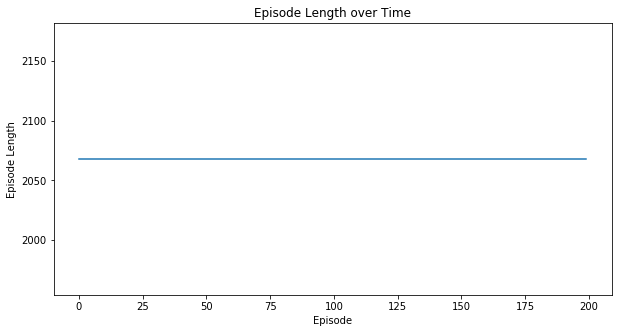

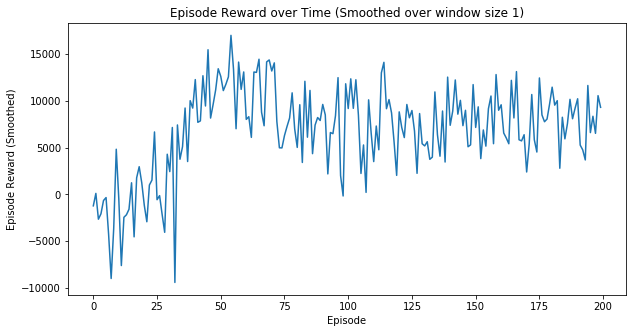

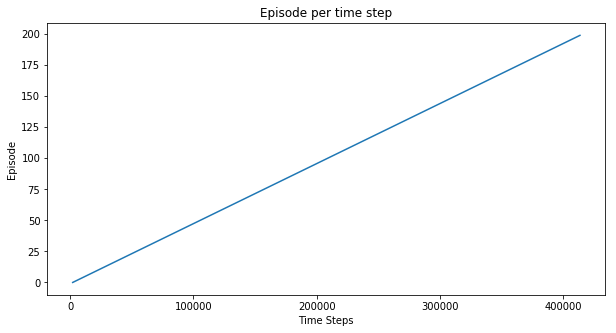

(<Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>)

In [44]:
plotting.plot_episode_stats(stats, smoothing_window=1)

In [46]:
print(stats.episode_rewards[100:].mean())
print(stats.episode_rewards[100:].min(), stats.episode_rewards[100:].max())

7692.992509470601
210.0438475045139 14108.016403345278


---

In [47]:
import fix_yahoo_finance as yf
import scipy.stats as sc_stats

In [48]:
testing_data = yf.download(["AAPL", "MSFT"], start="2019-01-01", end="2019-01-31")
testing_data

[*********************100%***********************]  2 of 2 downloaded


Open                    High                     Low  \
                  AAPL        MSFT        AAPL        MSFT        AAPL   
Date                                                                     
2018-12-31  158.529999  101.290001  159.360001  102.400002  156.479996   
2019-01-02  154.889999   99.550003  158.850006  101.750000  154.229996   
2019-01-03  143.979996  100.099998  145.720001  100.190002  142.000000   
2019-01-04  144.529999   99.720001  148.550003  102.510002  143.800003   
2019-01-07  148.699997  101.639999  148.830002  103.269997  145.899994   
2019-01-08  149.559998  103.040001  151.820007  103.970001  148.520004   
2019-01-09  151.289993  103.860001  154.529999  104.879997  149.630005   
2019-01-10  152.500000  103.220001  153.970001  103.750000  150.860001   
2019-01-11  152.880005  103.190002  153.699997  103.440002  151.509995   
2019-01-14  150.850006  101.900002  151.270004  102.870003  149.220001   
2019-01-15  150.270004  102.510002  153.389999  105.050003  150.050003   
2019-01-16  153.080002  105.260002  155.880005  106.260002  153.000000   
2019-01-17  154.199997  105.000000  157.660004  106.629997  153.259995   
2019-01-18  157.500000  107.459999  157.880005  107.900002  155.979996   
2019-01-22  156.410004  106.750000  156.729996  107.099998  152.619995   
2019-01-23  154.149994  106.120003  155.139999  107.040001  151.699997   
2019-01-24  154.110001  106.860001  154.479996  107.000000  151.740005   
2019-01-25  155.479996  107.239998  158.130005  107.879997  154.320007   
2019-01-28  155.789993  106.260002  156.330002  106.480003  153.660004   
2019-01-29  156.250000  104.879997  158.130005  104.970001  154.110001   
2019-01-30  163.250000  104.620003  166.149994  106.379997  160.229996   

                             Close               Adj Close              \
                  MSFT        AAPL        MSFT        AAPL        MSFT   
Date                                                                     
2018-12-31  100.440002  157.740005  101.570000  157.066376  101.138069   
2019-01-02   98.940002  157.919998  101.120003  157.245605  100.689987   
2019-01-03   97.199997  142.190002   97.400002  141.582779   96.985802   
2019-01-04   98.930000  148.259995  101.930000  147.626846  101.496536   
2019-01-07  100.980003  147.929993  102.059998  147.298264  101.625984   
2019-01-08  101.709999  150.750000  102.800003  150.106216  102.362839   
2019-01-09  103.239998  153.309998  104.269997  152.655289  103.826584   
2019-01-10  102.379997  153.800003  103.599998  153.143204  103.159431   
2019-01-11  101.639999  152.289993  102.800003  151.639633  102.362839   
2019-01-14  101.260002  150.000000  102.050003  149.359421  101.616028   
2019-01-15  101.879997  153.070007  105.010002  152.416321  104.563438   
2019-01-16  104.959999  154.940002  105.379997  154.278336  104.931862   
2019-01-17  104.760002  155.860001  106.120003  155.194397  105.668724   
2019-01-18  105.910004  156.820007  107.709999  156.150314  107.251953   
2019-01-22  104.860001  153.300003  105.680000  152.645340  105.230591   
2019-01-23  105.339996  153.919998  106.709999  153.262680  106.256210   
2019-01-24  105.339996  152.699997  106.199997  152.047897  105.748375   
2019-01-25  106.199997  157.759995  107.169998  157.086288  106.714249   
2019-01-28  104.660004  156.300003  105.080002  155.632523  104.633141   
2019-01-29  102.169998  154.679993  102.940002  154.019440  102.502243   
2019-01-30  104.330002  165.250000  106.379997  164.544296  105.927612   

              Volume            
                AAPL      MSFT  
Date                            
2018-12-31  35003500  33173800  
2019-01-02  37039700  35329300  
2019-01-03  91244100  42523600  
2019-01-04  58607100  44060600  
2019-01-07  54777800  35656100  
2019-01-08  41025300  31514400  
2019-01-09  45099100  32280800  
2019-01-10  35780700  30067600  
2019-01-11  27023200  28314200  
2019-01-14  32439200  28437100  
2019-01-15  28710900  31587600  
20

Length of testing data:  21 21
Minimum of AAPL testing data:  -5.877180658874437
Minimum of MSFT testing data:  -2.6037205108225265


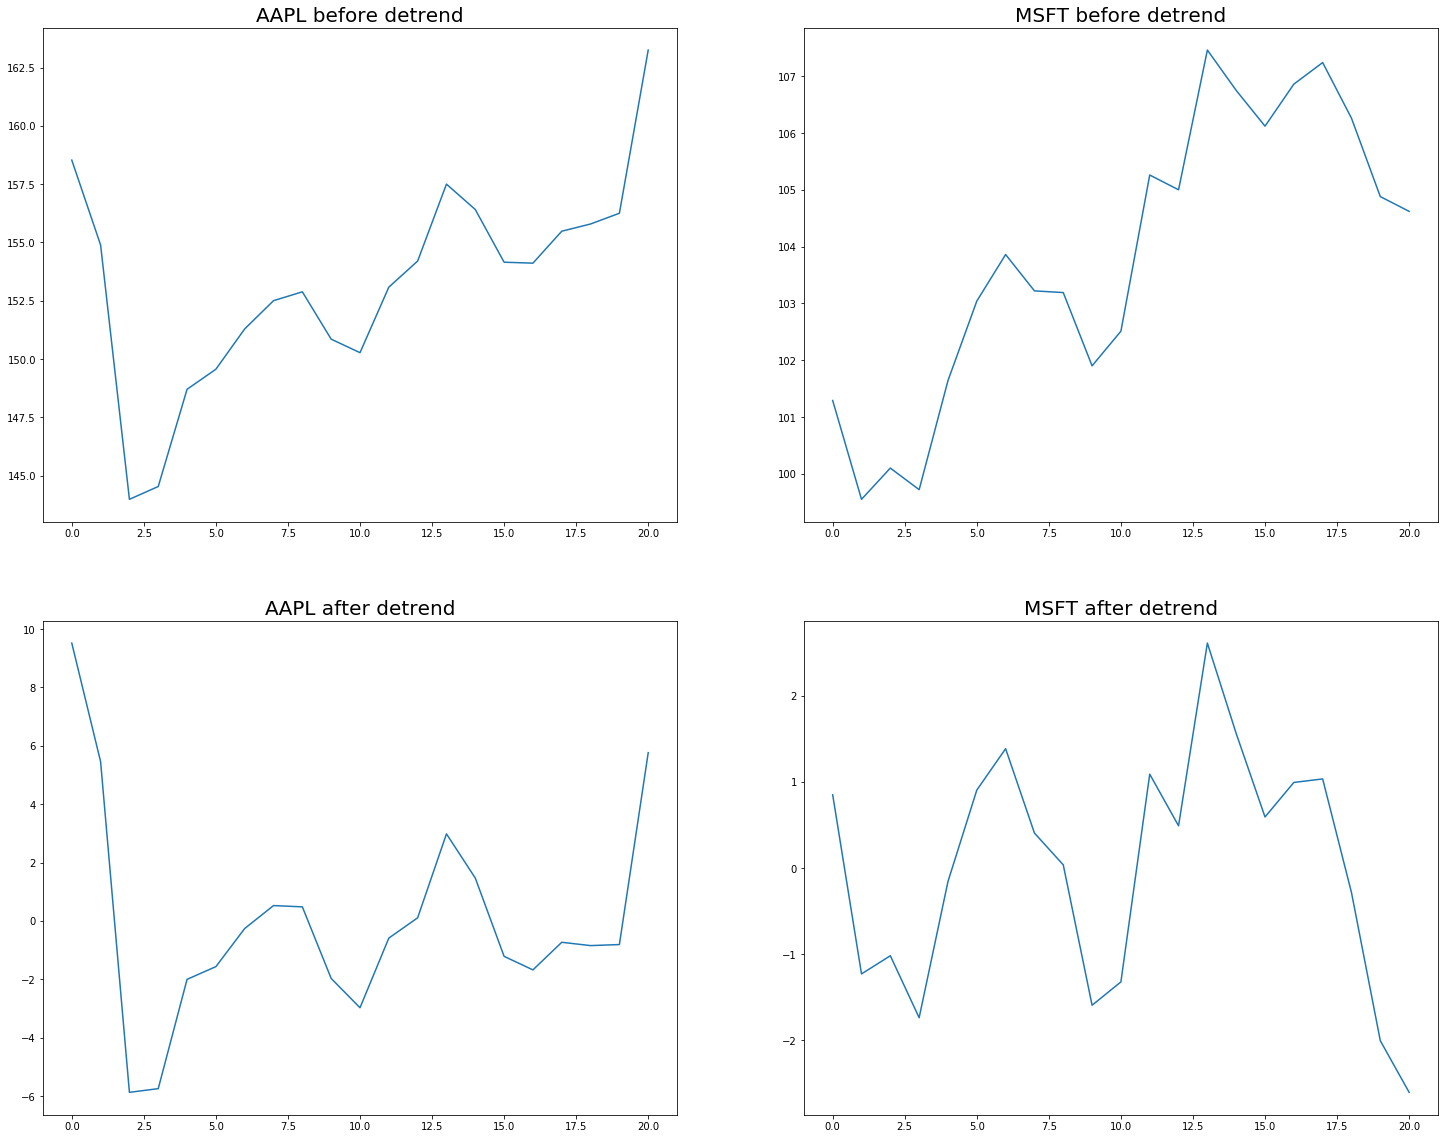

In [49]:
aapl_testing_open = testing_data.Open.AAPL
msft_testing_open = testing_data.Open.MSFT
detrended_aapl_testing_open = signal.detrend(aapl_testing_open)
detrended_msft_testing_open = signal.detrend(msft_testing_open)

plt.figure(figsize=(25,20))
plt.subplot(221)
plt.title("AAPL before detrend", fontsize=20)
plt.plot(range(0,len(aapl_testing_open)), aapl_testing_open)
plt.subplot(222)
plt.title("MSFT before detrend", fontsize=20)
plt.plot(range(0,len(msft_testing_open)), msft_testing_open)
plt.subplot(223)
plt.title("AAPL after detrend", fontsize=20)
plt.plot(range(0,len(detrended_aapl_testing_open)), detrended_aapl_testing_open)
plt.subplot(224)
plt.title("MSFT after detrend", fontsize=20)
plt.plot(range(0,len(detrended_msft_testing_open)), detrended_msft_testing_open)

print("Length of testing data: ", len(detrended_aapl_testing_open), len(detrended_msft_testing_open))
print("Minimum of AAPL testing data: ", detrended_aapl_testing_open.min())
print("Minimum of MSFT testing data: ", detrended_msft_testing_open.min())

In [50]:
# add the same value as to the training data
detrended_aapl_testing_open += 35
detrended_msft_testing_open += 35

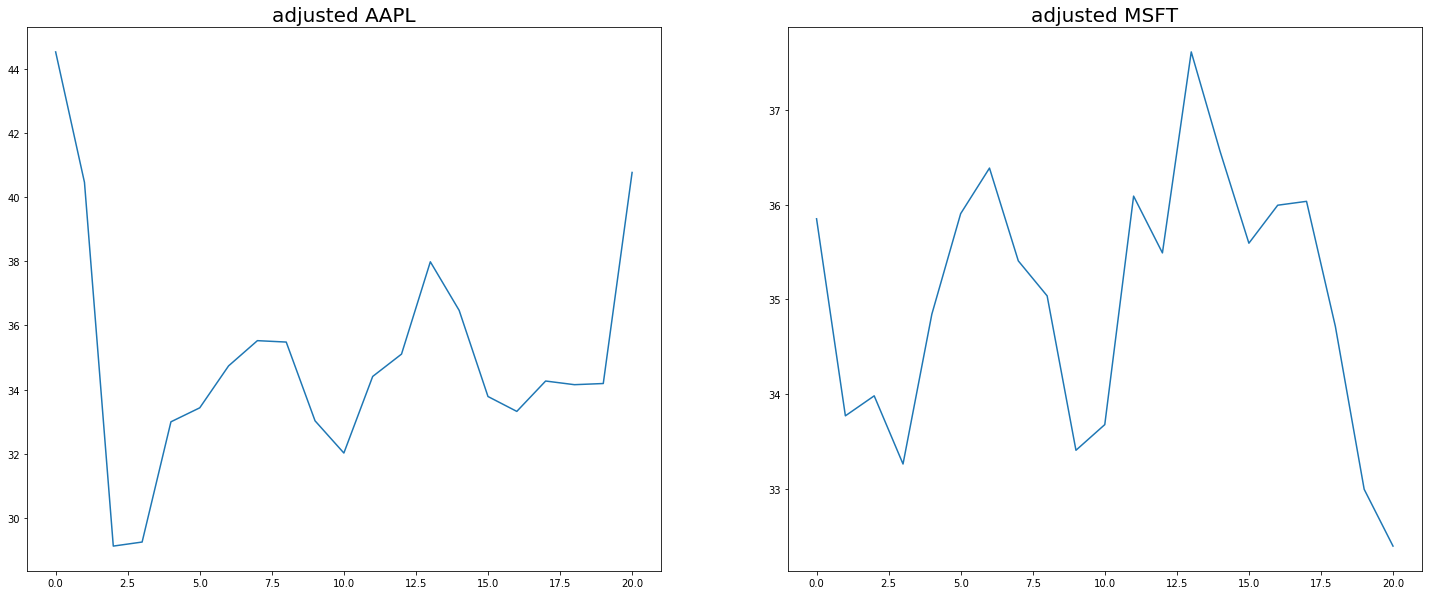

In [51]:
plt.figure(figsize=(25,10))
plt.subplot(121)
plt.title("adjusted AAPL", fontsize=20)
plt.plot(range(0,len(detrended_aapl_testing_open)), detrended_aapl_testing_open)
plt.subplot(122)
plt.title("adjusted MSFT", fontsize=20)
plt.plot(range(0,len(detrended_msft_testing_open)), detrended_msft_testing_open)

In [52]:
class TestingEnvironment1():
    def __init__(self, length, starting_ts=0, starting_cap=10000.):
        self.cur_timestep = starting_ts
        self.starting_cap = starting_cap
        self.length = length
        
        self.state = [0.,0.,0.,0.]
        self.state[0] = 100
        self.state[1] = 100
        self.state[2] = self.starting_cap - 100*detrended_aapl_testing_open[self.cur_timestep]\
                        - 100*detrended_msft_testing_open[self.cur_timestep]
        self.state[3] = self.portfolio_value()
        
    def portfolio_value(self):
        return (self.state[0]*detrended_aapl_testing_open[self.cur_timestep])\
                + (self.state[1]*detrended_msft_testing_open[self.cur_timestep])\
                + self.state[2]
    
    def step(self, action):
        cur_value = self.state[3]
        retval = None
        self.cur_timestep += 1
        action = [action, 1.]
        
        if action[0] == 4:
            new_state = [self.state[0], self.state[1], self.state[2], 0.]
            self.state = new_state
            self.state[3] = self.portfolio_value()
            if self.cur_timestep >= self.length-1:
                retval = self.state, 0., True, {"msg": "hold & done"}
            else:
                retval = self.state, 0., False, {"msg": "hold"}
        
        if action[0] == 0:
            if action[1]*detrended_aapl_testing_open[self.cur_timestep] > self.state[2]:
                new_state = [self.state[0], self.state[1], self.state[2], 0.]
                self.state = new_state
                self.state[3] = self.portfolio_value()
                if self.cur_timestep >= self.length-1:
                    retval = self.state, 0., True, {"msg": "bankrupted & done"}
                else:
                    retval = self.state, 0., False, {"msg": "bankrupted"}
            else:
                aapl_shares = self.state[0] + action[1]
                cash_spent = action[1] * detrended_aapl_testing_open[self.cur_timestep] +1. #* 1.1 # 10% brokerage fee
                new_state = [aapl_shares, self.state[1], self.state[2]-cash_spent, 0.]
                self.state = new_state
                self.state[3] = self.portfolio_value()
                gain = self.state[3] - cur_value
                if self.cur_timestep >= self.length-1:
                    retval = self.state, gain, True, {"msg": "bought AAPL & done"}
                else:
                    retval = self.state, gain, False, {"msg": "bought AAPL"}
                
        if action[0] == 2:
            if action[1]*detrended_msft_testing_open[self.cur_timestep] > self.state[2]:
                new_state = [self.state[0], self.state[1], self.state[2], 0.]
                self.state = new_state
                self.state[3] = self.portfolio_value()
                if self.cur_timestep >= self.length-1:
                    retval = self.state, 0., True, {"msg": "bankrupted & done"}
                else:
                    retval = self.state, 0., False, {"msg": "bankrupted"}
            else:
                msft_shares = self.state[1] + action[1]
                cash_spent = action[1] * detrended_msft_testing_open[self.cur_timestep] +1. #* 1.1 # 10% brokerage fee
                new_state = [self.state[0], msft_shares, self.state[2]-cash_spent, 0.]
                self.state = new_state
                self.state[3] = self.portfolio_value()
                gain = self.state[3] - cur_value
                if self.cur_timestep >= self.length-1:
                    retval = self.state, gain, True, {"msg": "bought MSFT & done"}
                else:
                    retval = self.state, gain, False, {"msg": "bought MSFT"}
                
        if action[0] == 1:
            if action[1] > self.state[0]:
                new_state = [self.state[0], self.state[1], self.state[2], 0.]
                self.state = new_state
                self.state[3] = self.portfolio_value()
                if self.cur_timestep >= self.length-1:
                    retval = self.state, 0., True, {"msg": "sold more AAPL than have & done"}
                else:
                    retval = self.state, 0., False, {"msg": "sold more AAPL than have"}
            else:
                aapl_shares = self.state[0] - action[1]
                cash_gained = action[1] * detrended_aapl_testing_open[self.cur_timestep] -1. #* 0.9 # 10% brokerage fee
                new_state = [aapl_shares, self.state[1], self.state[2]+cash_gained, 0.]
                self.state = new_state
                self.state[3] = self.portfolio_value()
                gain = self.state[3] - cur_value
                if self.cur_timestep >= self.length-1:
                    retval = self.state, gain, True, {"msg": "sold AAPL & done"}
                else:
                    retval = self.state, gain, False, {"msg": "sold AAPL"}
                
        if action[0] == 3:
            if action[1] > self.state[1]:
                new_state = [self.state[0], self.state[1], self.state[2], 0.]
                self.state = new_state
                self.state[3] = self.portfolio_value()
                if self.cur_timestep >= self.length-1:
                    retval = self.state, 0., True, {"msg": "sold more MSFT than have & done"}
                else:
                    retval = self.state, 0., False, {"msg": "sold more MSFT than have"}
            else:
                msft_shares = self.state[1] - action[1]
                cash_gained = action[1] * detrended_msft_testing_open[self.cur_timestep] -1. #* 0.9 # 10% brokerage fee
                new_state = [self.state[0], msft_shares, self.state[2]+cash_gained, 0.]
                self.state = new_state
                self.state[3] = self.portfolio_value()
                gain = self.state[3] - cur_value
                if self.cur_timestep >= self.length-1:
                    retval = self.state, gain, True, {"msg": "sold MSFT & done"}
                else:
                    retval = self.state, gain, False, {"msg": "sold MSFT"}
                
        return retval
    
    
    def reset(self):
        '''
        self.cur_timestep = starting_ts
        self.starting_cap = starting_cap
        
        self.state = [0.,0.,0.,0.]
        self.state[0] = 100
        self.state[1] = 100
        self.state[2] = self.starting_cap - 100*detrended_aapl_testing_open[self.cur_timestep]\
                        - 100*detrended_msft_testing_open[self.cur_timestep]
        self.state[3] = self.portfolio_value(self.cur_timestep)
        '''
        
        return self.state

In [53]:
print(detrended_aapl_testing_open)
print(detrended_msft_testing_open)

[44.52043274 40.45662754 29.12281934 29.24901714 32.99520995 33.43140575
 34.73759555 35.52379735 35.47999716 33.02619296 32.02238576 34.40857856
 35.10476837 37.98096617 36.46716497 33.78334977 33.31955158 34.26574138
 34.15193318 34.18813499 40.76432979]
[35.84991346 33.77073366 33.98154687 33.26236807 34.84318427 35.90400447
 36.38482267 35.40564087 35.03646007 33.40727827 33.67809648 36.08891468
 35.48973088 37.61054808 36.56136728 35.59218848 35.99300468 36.03381989
 34.71464209 32.99545529 32.39627949]


In [54]:
env = TestingEnvironment1(length=len(detrended_aapl_testing_open))

In [55]:
rewards = []
actions = []
states = []
next_state = env.reset()
states.append(next_state)

while(True):
    action_prob = estimator.predict(next_state)
    next_action = np.argmax(action_prob)
    state, reward, done, _ = env.step(next_action)
    rewards.append(reward)
    actions.append(next_action)
    states.append(state)
    if done:
        break
    next_state = state

In [57]:
print("rewards length: ", len(rewards))
print("actions length: ", len(actions))
print("states length: ", len(states))

rewards length:  20
actions length:  20
states length:  21


In [58]:
starting_portfolio_value = env.starting_cap
ending_portfolio_value = states[len(states)-1][3]
# portfolio value after holding the original portfolio for a particular period
benchmark_portfolio_value = states[0][0]*detrended_aapl_testing_open[-1]+states[0][1]*detrended_msft_testing_open[-1]\
                            +states[0][2]

data = {'state': states[0:-1], 'next_action': actions, 'reward': rewards}
result_df = pd.DataFrame(data)
result_df.loc[len(result_df),:] = [states[-1], '-', '-']

#total_reward = np.sum(rewards)
#result_df.loc[len(result_df),:] = ['', 'total reward(cash):', total_reward]

delta_portfolio_value = ending_portfolio_value - starting_portfolio_value
result_df.loc[len(result_df),:] = ['', 'change in portfolio value:', delta_portfolio_value]

rr = delta_portfolio_value / starting_portfolio_value * 100
result_df.loc[len(result_df),:] = ['', 'rate of return(actual change):', str(rr)+'%']

delta_benchmark_portfolio = benchmark_portfolio_value - starting_portfolio_value
result_df.loc[len(result_df),:] = ['', 'benchmark portfolio:',
                                   str(round(benchmark_portfolio_value,3)) + '(' + str(round(delta_benchmark_portfolio,3)) + ')']

rr_benchmark = delta_benchmark_portfolio / starting_portfolio_value * 100
result_df.loc[len(result_df),:] = ['', 'benchmark rate of return:', str(rr_benchmark)+'%']

pd.set_option('display.max_colwidth', 100)
result_df

,state,next_action,reward
0,"[100, 100, 1962.965380086575, 10000.0]",0,-615.298
1,"[101.0, 100, 1921.5087525480467, 9384.701500389609]",0,-1124.63
2,"[102.0, 100, 1891.3859332069212, 8260.068192581815]",0,-60.0457
3,"[103.0, 100, 1861.1369160631982, 8200.022488576622]",0,542.939
4,"[104.0, 100, 1827.141706116878, 8742.961967374024]",0,150.446
5,"[105.0, 100, 1792.7103003679601, 8893.408350974025]",0,184.232
6,"[106.0, 100, 1756.972704816445, 9077.640100376619]",0,-15.5808
7,"[107.0, 100, 1720.4489074623325, 9062.059311581814]",0,-42.6047
8,"[108.0, 100, 1683.9689103056226, 9019.454610589608]",0,-428.929
9,"[109.0, 100, 1649.9427173463152, 8590.525577399996]",0,-83.3332


mean:  -33.798918593506826
standard deviation:  412.81330419983965


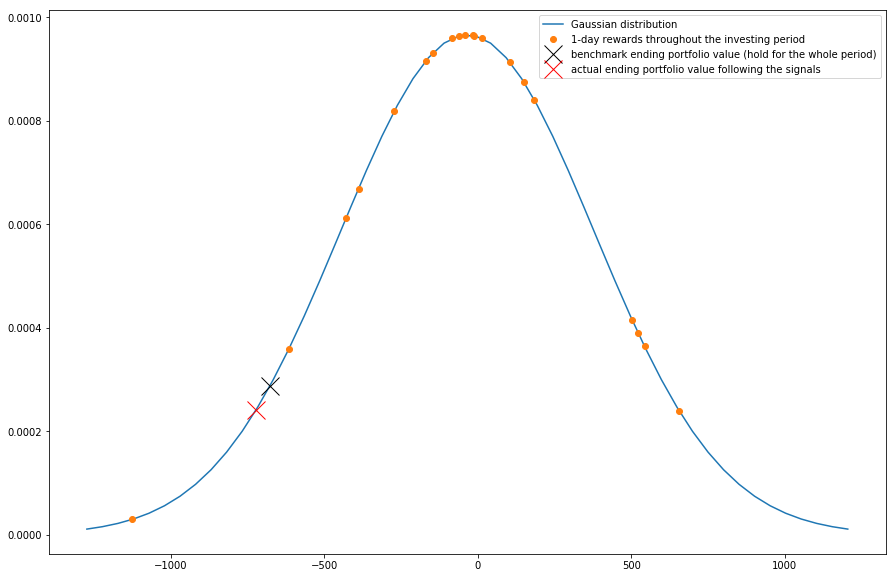

In [60]:
mu = np.mean(rewards)
sigma = np.std(rewards)
x = np.linspace(mu-3*sigma, mu+3*sigma)
print("mean: ", mu)
print("standard deviation: ", sigma)

plt.figure(figsize=(15,10))
plt.plot(x, sc_stats.norm.pdf(x, mu, sigma),
         label='Gaussian distribution')
plt.plot(rewards, sc_stats.norm.pdf(rewards, mu, sigma), 'o',
         label='1-day rewards throughout the investing period')
plt.plot(delta_portfolio_value, sc_stats.norm.pdf(delta_portfolio_value, mu, sigma), 'x', color='black', markersize=18,
         label='benchmark ending portfolio value (hold for the whole period)')
plt.plot(delta_benchmark_portfolio, sc_stats.norm.pdf(delta_benchmark_portfolio, mu, sigma), 'x', color='red',
         markersize=18, label='actual ending portfolio value following the signals')
plt.legend()